In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from utils import *
from loaders import *
from stan import *

plt.style.use('pcb')

In [2]:
filenames = pd.read_excel('data/tungsten recordings/droso/z7/name dose time.xlsx', index_col=[0,1], names=range(1,11))

In [3]:
filenames_z3 = pd.read_excel('data/tungsten recordings/z3/name dose time.xlsx', index_col=[0], names=range(1,14), header=None)

In [4]:
root = 'data/tungsten recordings/z3/'
suffix = '.smrx0.txt'

kdes_z3 = {}
spiketrains_z3 = {}

for dur in ['20ms','200ms','2000ms']:
    kdes_z3[dur] = []
    spiketrains_z3[dur] = []

    for j, fn in enumerate(filenames_z3.loc[dur].values):
        if j == 5:
            continue
            
        fn = str(fn)
        
        if fn != fn:
            continue
        
        # fn = fn[:6] + '0' + fn[6:]
        # parts = fn.split('_')
        # parts[-1] = '0' + parts[-1]
        # fn = '_'.join(parts)

        try:
            df = pd.read_csv(root + fn + suffix, sep='\t')
        except:
            print(fn)
            continue

        stim_start = df['Vanne1 ON'].iloc[0]
        # spiketrain = df['spike times'].values
        spiketrain = df['spike times'].values - stim_start

        if spiketrain[2] != spiketrain[2]:
            continue

        tarr = np.linspace(-2., 4, 1000)

        kde = get_kde(tarr, spiketrain, 0.05)
        kdes_z3[dur].append(kde)
        spiketrains_z3[dur].append(spiketrain)

In [5]:
durdose_root = 'data/tungsten recordings/doses/'

spikefiles_do = sorted(get_filenames(durdose_root, 'SPK'))
stimfiles_do = sorted(get_filenames(durdose_root, 'STIM'))

dudoe = DoseDurationExperiment(spikefiles_do[:], stimfiles_do[:])

In [6]:
kdes_z7 = []
spiketrains_z7 = []

for resp in dudoe['1ng','2000ms']:
    spiketrain = resp.spiketrain - resp.stim_start
    spiketrains_z7.append(spiketrain)
    kde = resp.kde(tarr, shift=True, bw=0.05)
    kdes_z7.append(kde)

In [7]:
root = 'data/tungsten recordings/droso/cVA'
files_cva = sorted([root + '/' + x for x in os.listdir(f'{root}') if 'txt' in x])

In [8]:
kdes_cva = []
spiketrains_cva = []

for i in range(8):
    spiketrain = pd.read_csv(files_cva[i], sep='\t')['spike times'].values

    rec = SpikeRecording(spiketrain, 0, 120)
    resp = SpikingResponse(rec, 60.0, 62.0)
    
    spiketrains_cva.append(resp.spiketrain - resp.stim_start)
#     resp = SpikingResponse.from_files(files[i])

    tarr = np.linspace(-2, 4, 1000)  # -1
    kde = resp.kde(tarr, shift=True, bw=0.05)
    kdes_cva.append(kde)
#     print(((spiketrain > 60) & (spiketrain < 62)).sum())

kde_avg = np.mean(kdes_cva, axis=0)

In [9]:
def bs_plot(tarr, kdes, ax, color='C0', label=None, lw=1):
    l = len(kdes)
    kdes = np.array(kdes)
    confidence = np.percentile(kdes[np.random.choice(l, size=(l,10000)),:].mean(axis=0), [2.5,97.5], axis=0)
    
    ax.fill_between(tarr, confidence[0], confidence[1], color=color, alpha=0.2)
    ax.plot(tarr, np.mean(kdes,axis=0), lw=lw, color=color, label=label)

In [10]:
root = 'data/tungsten recordings/droso/z7/'
suffix = '.smrx0.txt'

kdes = {}

for dose in ['10ng','100ng']:
    kdes[dose] = {}
    for dur in ['20ms','200ms','2000ms']:
        kdes[dose][dur] = []
        
        for fn in filenames.loc[dose,dur].values:
            if fn != fn:
                continue

            parts = fn.split('_')
            parts[-1] = '0' + parts[-1]
            fn = '_'.join(parts)

            try:
                df = pd.read_csv(root + fn + suffix, sep='\t')
            except:
                print(fn)
                continue

            stim_start = df['Vanne1 ON'].iloc[0]
            # spiketrain = df['spike times'].values
            spiketrain = df['spike times'].values - stim_start

            if spiketrain[2] != spiketrain[2]:
                continue

            tarr = np.linspace(-2., 4, 1000)  # -1

            kde = get_kde(tarr, spiketrain, 0.05)
            kdes[dose][dur].append(kde)

2023_01_10_0013
2023_01_10_0022
2023_01_10_0023


In [36]:
# def bs_plot(tarr, kdes, ax, color='C0'):
#     l = len(kdes)
#     kdes = np.array(kdes)
#     confidence = np.percentile(kdes[np.random.choice(l, size=(l,2000)),:].mean(axis=0), [2.5,97.5], axis=0)
    
#     ax.fill_between(tarr, confidence[0], confidence[1], color=color, alpha=0.2)
#     ax.plot(tarr, np.mean(kdes,axis=0), lw=1, color=color)

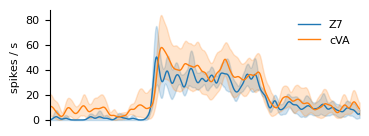

In [11]:
fig, ax = plt.subplots(figsize=(4,1.5))

def plot_cva_z7(ax):
    dose = '100ng'
    dur = '2000ms'

    bs_plot(tarr, kdes[dose][dur], ax, color='C0', label='Z7')
    bs_plot(tarr, kdes_cva, ax, color='C1', label='cVA')

    ax.set_xlim(-2,4)

    ax.set_ylabel('spikes / s')
    # ax.set_xlabel('time (s)')
    despine_ax(ax, 'b')
    ax.legend(frameon=False)
    

plot_cva_z7(ax)
plt.savefig('img/cva_presentation.png')

In [ ]:
fig, ax = plt.subplots(figsize=(4,1.5))

def plot_z7_z3(ax):
    bs_plot(tarr, kdes_z7, ax, color='C0', label='Z7')
    bs_plot(tarr, kdes_z3['2000ms'], ax, color='C2', label='Z3')
    ax.set_xlim(-2,4)

    ax.set_ylabel('spikes / s')
    despine_ax(ax, 'b')

    ax.legend(frameon=False)
    
plot_z7_z3(ax)

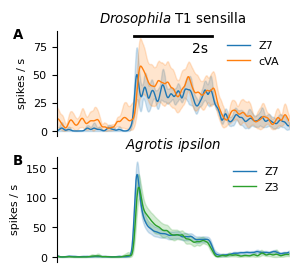

In [62]:
fig, axes = plt.subplots(nrows=2, figsize=(3,3), sharex=True)

plot_cva_z7(axes[0])
plot_z7_z3(axes[1])

axes[0].set_title(r'$\it{Drosophila}$ T1 sensilla')
axes[1].set_title(r'$\it{Agrotis\ ipsilon}$')

axes[0].set_title('A', loc='left', fontweight='bold', x=-0.19, y=0.85)
axes[1].set_title('B', loc='left', fontweight='bold', x=-0.19, y=0.85)

axes[0].plot([0,2], [85, 85], lw=2, color='black')
axes[0].text(1.5, 70, '2s', fontsize=10)

# axes[0].set_xlim(-2,2)
# axes[1].set_xlim(-2,2)

plt.savefig('img/droso_agrotis_compare.png')

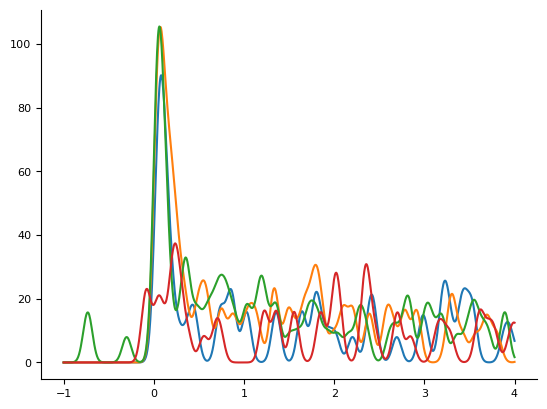

In [84]:
for kde in kdes['100ng']['200ms']:
    plt.plot(tarr, kde)